In [1]:
import numpy as np
import torch

In [2]:
#define some useful functions
def generate_HMM_params(num_hidden_state, num_obs):
    # random generate the transition matrix and observation matrix, and compute the stationary distribution
    
    alpha_state = np.ones(num_hidden_state)
    alpha_obs = np.ones(num_obs) / num_obs
    trans_mat = np.random.dirichlet(alpha_state, num_hidden_state)
    obs_mat = np.random.dirichlet(alpha_obs, num_hidden_state)
    tmp = np.ones((num_hidden_state + 1, num_hidden_state))
    tmp[:-1] = np.identity(num_hidden_state) - trans_mat.T
    tmp_v = np.zeros(num_hidden_state + 1)
    tmp_v[-1] = 1
    stat_dist = np.linalg.lstsq(tmp, tmp_v, rcond=None)[0]
    return trans_mat, obs_mat, stat_dist

In [3]:
def generate_HMM_sequences(trans_mat, obs_mat, init_dist, length, num_samples = 1):
    # generate sample sequences from HMM
    
    states = np.zeros((num_samples, length))
    obs = np.zeros((num_samples, length))
    tmp_state = np.argmax(np.random.multinomial(1, init_dist, num_samples), axis = 1)
    #print(tmp_state)
    for i in range(length):
        #print("i: ", i)
        states[:, i] = tmp_state
        for j in range(num_samples):
            obs[j, i] = np.random.multinomial(1, obs_mat[tmp_state[j]]).argmax()
            tmp_state[j] = np.random.multinomial(1, trans_mat[tmp_state[j]]).argmax()
        #print("obs[:, i]: ", obs[:, i])
    return states, obs

In [4]:
def forward_compute(trans_mat, obs_mat, init_dist, obs_to_pos):
    # compute \sum_{h_1,...,h_{pos-1}} P(h_1,...,h_{pos},x_1,...,x_{pos-1})
    pos = obs_to_pos.shape[0] + 1
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    forward = np.zeros((pos, num_hidden_state))
    forward[0] = init_dist
    for i in range(1, pos):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                #print(i, j, k)
                #print(forward[i - 1, k], trans_mat[k, j], obs_mat[k, int(obs_to_pos[i - 1])])
                forward[i, j] += forward[i - 1, k] * trans_mat[k, j] * obs_mat[k, int(obs_to_pos[i - 1])]
    #print("forward: ", forward)
    return forward[pos - 1]

In [5]:
def backward_compute(trans_mat, obs_mat, obs_from_pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    back_length = obs_from_pos.shape[0]
    if (back_length == 0):
        return np.ones(num_hidden_state)
    backward = np.zeros((back_length, num_hidden_state))
    for j in range(num_hidden_state):
         for k in range(num_hidden_state):
            backward[0, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-1])]
    for i in range(1, back_length):
        for j in range(num_hidden_state):
            for k in range(num_hidden_state):
                backward[i, j] += trans_mat[j, k] * obs_mat[k, int(obs_from_pos[-(i + 1)])] * backward[i - 1, k]
    #print("backward: ", backward)
    return backward[-1]

In [6]:
def x_i_conditional_prob(trans_mat, obs_mat, init_dist, known_X, pos):
    num_hidden_state = trans_mat.shape[0]
    num_obs = obs_mat.shape[1]
    num_samples = known_X.shape[0]
    length = known_X.shape[1]
    x_pos_conditional_prob = np.zeros((num_samples, num_obs))
    h_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    h_all_pos_conditional_prob = np.zeros((num_samples, num_hidden_state))
    for i in range(num_samples):
        #print("x_i_conditional_prob: i=", i)
        sample_obs_vec = known_X[i]
        forward_vec = forward_compute(trans_mat, obs_mat, init_dist, known_X[i, :pos[i]])
        backward_vec = backward_compute(trans_mat, obs_mat, known_X[i, pos[i] + 1:])
        #print("forward_vec: ", forward_vec)
        #print("backward_vec: ", backward_vec)
        h_prob_tmp = forward_vec * backward_vec
        tmp = h_prob_tmp.sum()
        h_prob_tmp /= tmp
        h_pos_conditional_prob[i] = h_prob_tmp
        x_pos_conditional_prob[i] = h_prob_tmp @ obs_mat
        h_all_pos_conditional_prob[i] = h_prob_tmp * obs_mat[:, int(known_X[i, pos[i]])] / x_pos_conditional_prob[i, int(known_X[i, pos[i]])]
    return h_pos_conditional_prob, x_pos_conditional_prob, h_all_pos_conditional_prob

In [7]:
#parameter setting
num_hidden_state = 3
num_obs = 5
length = 10
num_samples = 1000

In [8]:
seed = 20211018
np.random.seed(seed)
trans_mat, obs_mat, stat_dist = generate_HMM_params(num_hidden_state, num_obs) # generate parameters for HMM

states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix")
print(trans_mat)
print("observation matrix")
print(obs_mat)
print("stationary distribution")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5: ")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5: 
[[1. 1. 0. 0. 0. 2. 0. 1. 0. 1. 0. 1. 0. 3. 3. 1. 1. 0. 3. 1.]
 [1. 1. 0. 0. 1. 1. 0. 1. 1. 1. 1. 4. 3. 3. 4. 1. 0. 4. 1. 1.]
 [0. 2. 0. 2. 0. 2. 2. 2. 1. 0. 3. 1. 1. 1. 0. 1. 1. 1. 1. 1.]
 [0. 2. 2. 0. 1. 0. 2. 1. 2. 0. 1. 1. 1. 3. 1. 0. 1. 1. 1. 2.]
 [1. 0. 1. 0. 2. 1. 1. 1. 0. 1. 4. 1. 4. 1. 1. 0. 1. 0. 3. 3.]]
positions, only showing first 5:  [9 4 6 2 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.21892801 0.54738046 0.

In [9]:
from torch import nn
from torch.utils import data

In [34]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.linearnetwork = nn.Sequential(
            nn.Linear(num_obs, num_hidden_state, bias=False)
        )
        self.linearnetwork_h = nn.Sequential(
            nn.Linear(num_obs, num_hidden_state, bias=False)
        )
    
    def forward(self, x, ind_x):
        logits = self.linearnetwork(ind_x)
        h = self.linearnetwork_h(x)
        return nn.Softmax(dim = 1)(torch.log(h) + logits)

In [35]:
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1
#print(pos[:9])
#print(obs[:9])
#print(x_one_hot[:9])

In [36]:
features1, features2, labels = x, x_one_hot, hh

In [44]:
# Model parameters.
lr = 1
epochs = 10000
batch_size = 100

In [45]:
dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
train_dl = data.DataLoader(dataset, batch_size=batch_size, shuffle=False)

In [46]:
net = NeuralNetwork()
nn.init.constant_(net.linearnetwork_h[0].weight, 1)

Parameter containing:
tensor([[1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1.]], requires_grad=True)

In [47]:
loss = nn.KLDivLoss(reduction='batchmean')

In [48]:
trainer = torch.optim.SGD(net.parameters(), lr=lr)

In [49]:
total_loss_lst = []
for i in range(epochs):
    total_loss = 0
    for X1, X2, y in train_dl:
        l = loss(torch.log(net(X1, X2)), y)
        #l = shiftedNegLLLoss(net(X1, X2), y)
        total_loss += l
        trainer.zero_grad()
        l.backward()
        trainer.step()
    if (i % 100 == 0):
        print("epoch: ", i)
        print("loss: ", total_loss)
        total_loss_lst.append(total_loss)

epoch:  0
loss:  tensor(2.1198, grad_fn=<AddBackward0>)
epoch:  100
loss:  tensor(0.0580, grad_fn=<AddBackward0>)
epoch:  200
loss:  tensor(0.0421, grad_fn=<AddBackward0>)
epoch:  300
loss:  tensor(0.0329, grad_fn=<AddBackward0>)
epoch:  400
loss:  tensor(0.0260, grad_fn=<AddBackward0>)
epoch:  500
loss:  tensor(0.0209, grad_fn=<AddBackward0>)
epoch:  600
loss:  tensor(0.0169, grad_fn=<AddBackward0>)
epoch:  700
loss:  tensor(0.0140, grad_fn=<AddBackward0>)
epoch:  800
loss:  tensor(0.0117, grad_fn=<AddBackward0>)
epoch:  900
loss:  tensor(0.0099, grad_fn=<AddBackward0>)
epoch:  1000
loss:  tensor(0.0085, grad_fn=<AddBackward0>)
epoch:  1100
loss:  tensor(0.0073, grad_fn=<AddBackward0>)
epoch:  1200
loss:  tensor(0.0064, grad_fn=<AddBackward0>)
epoch:  1300
loss:  tensor(0.0056, grad_fn=<AddBackward0>)
epoch:  1400
loss:  tensor(0.0049, grad_fn=<AddBackward0>)
epoch:  1500
loss:  tensor(0.0042, grad_fn=<AddBackward0>)
epoch:  1600
loss:  tensor(0.0037, grad_fn=<AddBackward0>)
epoch:  1

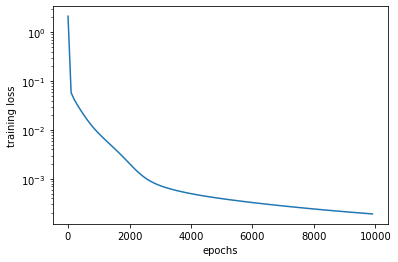

In [50]:
import matplotlib.pyplot as plt
x_lst = list(range(0, 10000, 100))
plt.plot(x_lst, total_loss_lst)
plt.yscale('log')
plt.xlabel("epochs")
plt.ylabel("training loss")
plt.show()

In [51]:
print("learned matrix:")
print(net.linearnetwork[0].weight.data.numpy())
print("log(O):")
print(np.log(obs_mat))
print("Difference:")
print(net.linearnetwork[0].weight.data.numpy() - np.log(obs_mat))

learned matrix:
[[ 0.89628845 -1.1770345  -0.9938493   3.8384502   0.6095001 ]
 [ 0.8236614   0.34915718 -0.21126103  1.3891723   3.6333191 ]
 [-2.3793757   0.32312828  0.4282125  -5.0138817  -4.623234  ]]
log(O):
[[ -1.25729566  -1.38032328  -4.32893177  -0.82547526  -4.35268422]
 [ -1.89086747  -0.41556183  -4.10711787  -3.83531198  -1.89021013]
 [ -4.70896735  -0.05633851  -3.08419628 -23.26446841 -21.49641299]]
Difference:
[[ 2.15358412  0.20328878  3.33508249  4.66392545  4.96218433]
 [ 2.71452886  0.76471902  3.89585684  5.2244843   5.52352927]
 [ 2.32959165  0.37946679  3.51240877 18.25058673 16.8731792 ]]


In [54]:
print("learned matrix:")
print(net.linearnetwork_h[0].weight.data.numpy().T)
print("pseudo inv of O:")
print(np.linalg.pinv(obs_mat))
print("Difference:")
print(net.linearnetwork_h[0].weight.data.numpy().T - np.linalg.pinv(obs_mat))

learned matrix:
[[ 0.39010373  1.8261852  -2.6486025 ]
 [ 0.008606    0.00922457  1.2635484 ]
 [ 1.1878589   0.67104965  1.4508202 ]
 [ 3.0848243  -1.3024158   1.0486238 ]
 [-1.1736768   3.598973   -3.2347605 ]]
pseudo inv of O:
[[ 5.33398346e-01  2.62833064e+00 -1.97029301e+00]
 [-9.48583761e-03 -2.97974301e-03  1.06001933e+00]
 [ 9.08540466e-02 -4.56127065e-01  3.45443693e-01]
 [ 1.96231049e+00 -1.81806331e+00  7.42823603e-01]
 [-7.82054374e-01  4.31680259e+00 -2.80659284e+00]]
Difference:
[[-0.14329462 -0.80214541 -0.67830948]
 [ 0.01809184  0.01220431  0.20352905]
 [ 1.09700489  1.12717672  1.10537651]
 [ 1.12251384  0.51564747  0.3058002 ]
 [-0.39162247 -0.71782955 -0.42816768]]


In [55]:
net.eval()

NeuralNetwork(
  (linearnetwork): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=False)
  )
  (linearnetwork_h): Sequential(
    (0): Linear(in_features=5, out_features=3, bias=False)
  )
)

In [56]:
states, obs = generate_HMM_sequences(trans_mat, obs_mat, stat_dist, length, num_samples) # generate sample sequences

pos = np.random.randint(length, size = num_samples)

print("transition matrix:")
print(trans_mat)
print("observation matrix:")
print(obs_mat)
print("stationary distribution:")
print(stat_dist)
print("states and observations, first half of each row is states, only showing first 5:")
print(np.concatenate((states, obs), axis = 1)[:5])
print("positions, only showing first 5: ", pos[:5])
h, x, hh = x_i_conditional_prob(trans_mat, obs_mat, stat_dist, obs, pos)
print("Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(h[:5])
print("Pr[X_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(x[:5])
print("Pr[H_i|x_i,x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:")
print(hh[:5])

transition matrix:
[[0.19038151 0.5603291  0.24928939]
 [0.59211519 0.37810341 0.0297814 ]
 [0.52737761 0.34205379 0.1305686 ]]
observation matrix:
[[2.84422161e-01 2.51497236e-01 1.31816210e-02 4.38026768e-01
  1.28722143e-02]
 [1.50940815e-01 6.59969385e-01 1.64551320e-02 2.15946003e-02
  1.51040067e-01]
 [9.01408117e-03 9.45219115e-01 4.57668030e-02 7.87716140e-11
  4.61558184e-10]]
stationary distribution:
[0.41619456 0.44908825 0.1347172 ]
states and observations, first half of each row is states, only showing first 5:
[[0. 1. 0. 0. 2. 1. 0. 2. 0. 2. 0. 0. 0. 0. 1. 0. 3. 1. 1. 1.]
 [0. 2. 0. 1. 1. 0. 2. 1. 0. 1. 3. 1. 3. 4. 1. 3. 1. 4. 0. 1.]
 [1. 0. 1. 0. 2. 0. 1. 1. 0. 1. 1. 0. 1. 1. 1. 0. 0. 1. 1. 1.]
 [2. 0. 0. 1. 0. 1. 0. 2. 2. 1. 1. 1. 1. 1. 1. 4. 3. 1. 1. 0.]
 [0. 1. 0. 1. 1. 1. 0. 1. 1. 1. 3. 1. 1. 1. 1. 1. 0. 1. 1. 1.]]
positions, only showing first 5:  [2 2 5 8 1]
Pr[H_i|x_-i], j-th row is for j-th sample and i=positions[j], only showing first 5:
[[0.2431274  0.58828537 

In [57]:
x_one_hot = np.zeros((num_samples, num_obs))
for i in range(num_samples):
    x_one_hot[i, int(obs[i, pos[i]])] = 1

In [58]:
features1, features2, labels = x, x_one_hot, hh

In [59]:
test_dataset = data.TensorDataset(torch.FloatTensor(features1), torch.FloatTensor(features2), torch.FloatTensor(labels))
test_dl = torch.utils.data.DataLoader(test_dataset, batch_size=num_samples, shuffle=False)

In [62]:
for X1, X2, y in test_dl:
    print(loss(torch.log(net(X1, X2)), y))
    print(net(X1, X2)[:5])
    print(y[:5])

tensor(1.8436e-05, grad_fn=<DivBackward0>)
tensor([[4.3322e-01, 5.5728e-01, 9.5045e-03],
        [9.7290e-01, 2.7086e-02, 1.2877e-05],
        [5.4537e-01, 4.4871e-01, 5.9128e-03],
        [2.0881e-01, 6.1887e-01, 1.7232e-01],
        [1.0937e-01, 5.2782e-01, 3.6280e-01]], grad_fn=<SliceBackward>)
tensor([[4.3364e-01, 5.5683e-01, 9.5296e-03],
        [9.7287e-01, 2.7129e-02, 1.9529e-11],
        [5.4515e-01, 4.4889e-01, 5.9508e-03],
        [2.0811e-01, 6.1825e-01, 1.7364e-01],
        [1.0873e-01, 5.2626e-01, 3.6501e-01]])
